In [11]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns

from sklearn.metrics import accuracy_score

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
#import torchvision.transforms as tt

from tqdm.notebook import tqdm

from utils.metrics import recall_k, ndcg_k
from data.dataset_creation import DatasetInit, CustomDatasetSmall, CustomDatasetLarge, ToDevice

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from scipy.sparse import coo_matrix
import numpy as np

import wandb
import os
os.environ["WANDB_API_KEY"] = '0df87019b9f607855a97d62699a36b21b11eea04'

import numpy as np
import random
import torch
import os

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

from tqdm import tqdm

In [8]:
####
history_len=20
item_embed_size=128
user_embed_size=32

user_item_hidden_size = 128
user_item_history_hidden_size = 128
lstm_hidden_size = 128
dense_1_hidden_size = 128
dense_2_hidden_size = 128

dataset_name = 'dunnhumby_cj'
###

In [9]:
path_train = f'./data/{dataset_name}/train_baskets.csv'
path_test = f'./data/{dataset_name}/test_baskets.csv'
path_val = f'./data/{dataset_name}/valid_baskets.csv'


In [10]:
df_train = pd.read_csv(path_train)
df_val = pd.read_csv(path_val)
df_test = pd.read_csv(path_test)

In [13]:
item_counts = df_train.groupby(['item_id']).size().to_frame(name = 'item_count').reset_index()
item_counts = item_counts[item_counts['item_count']>= 3]

new_df_train = df_train[df_train['item_id'].isin(list(item_counts['item_id']))]

basket_per_user = new_df_train[['user_id','basket_id']].drop_duplicates().groupby('user_id').agg({'basket_id':'count'}).reset_index()

<AxesSubplot:xlabel='basket_id', ylabel='Probability'>

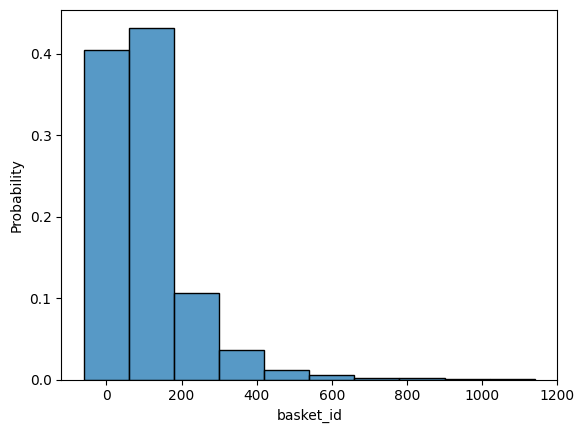

In [15]:
# basket per user distribution
sns.histplot(basket_per_user[basket_per_user['basket_id'] > 3]['basket_id'], stat="probability", bins=[-60, 60] + [60 + i * 120 for i in range(1, 10)])

<AxesSubplot:xlabel='item_id', ylabel='Probability'>

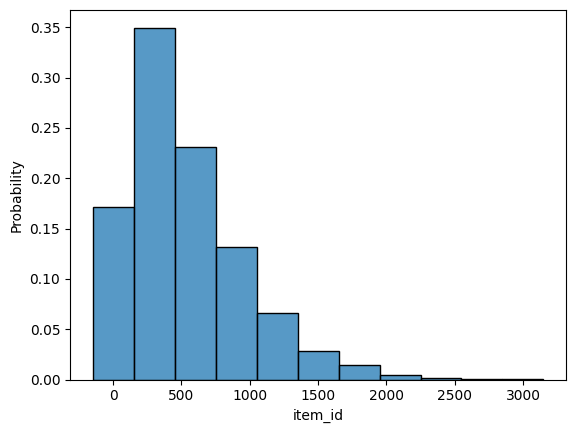

In [16]:
# number of unique items per user

item_counts = df_train.groupby(['item_id']).size().to_frame(name = 'item_count').reset_index()
item_counts = item_counts[item_counts['item_count']>= 5]
item_counts_dict = dict(zip(item_counts['item_id'],item_counts['item_count']))


values = new_df_train[['user_id','item_id']].drop_duplicates().groupby('user_id').agg({'item_id':'count'}).reset_index()['item_id']
sns.histplot(values,stat="probability", bins=[-150, 150] + [150 + i * 300 for i in range(1, 11)])

In [20]:
# average unique items per user
new_df_train[['user_id', 'item_id']].drop_duplicates().groupby('user_id').count()['item_id'].mean()

533.6980376451742

In [21]:
# average baskets per user
new_df_train[['user_id', 'basket_id']].drop_duplicates().groupby('user_id').count()['basket_id'].mean()

108.9150981177413

In [22]:
# average items in basket
new_df_train[['basket_id', 'item_id']].drop_duplicates().groupby('basket_id').count()['item_id'].mean()

9.231647184706631

In [23]:
# average repetition ratio
last_date_per_user = new_df_train.groupby('user_id').max()['date']

last_basket_dict = {}
for idx, (user_id, date) in tqdm(enumerate(last_date_per_user.items())):
    last_basket_dict[user_id] = set(new_df_train[(new_df_train['user_id'] == user_id) & (new_df_train['date'] == date)]['item_id'].values)

prev_basket_dict = {}
for idx, (user_id, date) in tqdm(enumerate(last_date_per_user.items())):
    prev_basket_dict[user_id] = set(new_df_train[(new_df_train['user_id'] == user_id) & (new_df_train['date'] != date)]['item_id'].values)

avg_rep_ratio = []
for idx, user_id in enumerate(prev_basket_dict):
#     print(len(prev_basket_dict[user_id]))
    avg_rep_ratio.append([user_id, len(last_basket_dict[user_id] & prev_basket_dict[user_id])/len(last_basket_dict[user_id])])
avg_rep_ratio_df = pd.DataFrame(avg_rep_ratio, columns=['user_id', 'avg_rep_ratio'])

2497it [00:20, 124.46it/s]
2497it [00:17, 141.73it/s]


In [24]:
# mean average repetition ratio
avg_rep_ratio_df['avg_rep_ratio'].mean()

0.4820090580491244

<AxesSubplot:xlabel='avg_rep_ratio', ylabel='Probability'>

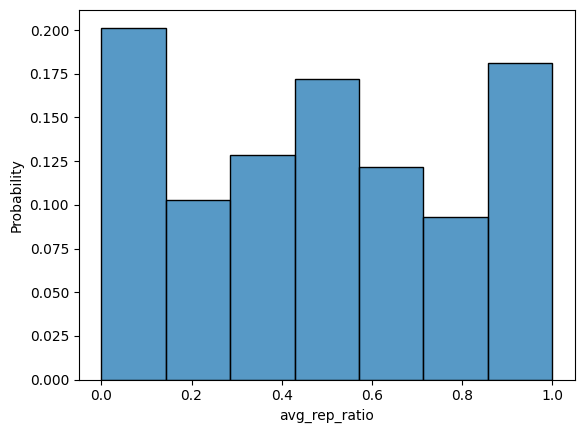

In [26]:
sns.histplot(avg_rep_ratio_df['avg_rep_ratio'],stat="probability", bins=7, binrange=(0, 1))

<AxesSubplot:>

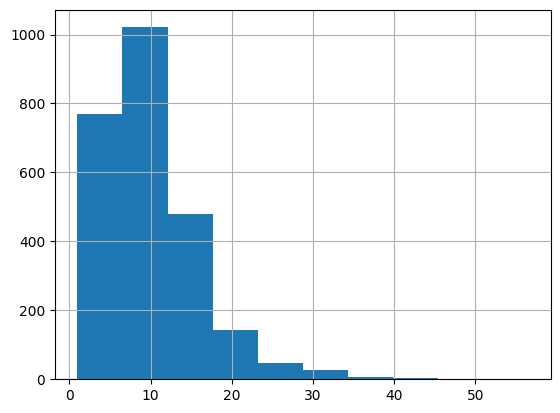

In [27]:
avg_item_per_basket = new_df_train.groupby(['basket_id']).count()[['item_id']]

avg_item_per_basket = new_df_train.groupby(['basket_id']).count()[['item_id']]
temp = new_df_train[['user_id', 'basket_id']].drop_duplicates()
temp = pd.merge(
    left=temp,
    right=avg_item_per_basket,
    how='inner',
    on='basket_id'
)
temp.groupby('user_id').mean()['item_id'].hist(bins=10)

In [28]:
dataset = DatasetInit(
    path_train=path_train,
    path_val=path_val,
    path_test=path_test,
    dataset=dataset_name,
    history_len=history_len,
    basket_count_min=3,
    min_item_count=5
    )

number of test users: 2483
items: 91764
filtered items: 36963


In [29]:
batch_size = 10000 

train_dataset = CustomDatasetLarge(
    dataset=dataset, 
    mode='train'
    )
# train_dataset = CustomDatasetSmall(
#     dataset=dataset, 
#     mode='train'
#     )
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True
    )

val_dataset = CustomDatasetSmall(
    dataset=dataset, 
    mode='val'
    )
val_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=batch_size, 
    shuffle=False
    )

test_dataset = CustomDatasetSmall(
    dataset=dataset, 
    mode='test'
    )
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
    )

Data allready in use


In [30]:
train = pd.read_csv(path_train)
test_users = dataset.test_users

max_bucket_len = max(train.groupby('basket_id').item_id.count())
max_num_baskets = max(train.groupby('user_id').basket_id.nunique())

In [31]:
def p_pop(train, test_users, n=max_num_baskets):
    result = {}
    top_popular = train.item_id.value_counts().index.tolist()[:max_bucket_len]
    train = train.sort_values(by='date')
    
    for user in tqdm(test_users):
        items = train[train.user_id==user]
        dates = items.date.unique()[-n:]
        top_personal = items[items.date.isin(dates)].item_id.value_counts().index.tolist()[:max_bucket_len]
    
        result[user] = top_personal
    
    return result

In [32]:
test_baskets = pd.read_csv(path_test)
user_test_baskets_df = test_baskets.groupby('user_id')['item_id'].apply(list).reset_index()
user_test_baskets_dict = dict(zip( user_test_baskets_df['user_id'],user_test_baskets_df['item_id']))

user_predictions = p_pop(train, test_users, n=50)
final_users = set(dataset.test_users).intersection(set(list(user_test_baskets_dict.keys())))
print('predictions ready',len(user_predictions))
print('number of final test users:',len(final_users))
for k in [5,10,20,'B']:
    print(k)
    recall_scores = {}
    ndcg_scores = {}

    for user in final_users:

        top_items = []
        if user in user_predictions:
            top_items = user_predictions[user]

        if k == 'B':
            recall_scores[user] = recall_k(user_test_baskets_dict[user],top_items,len(user_test_baskets_dict[user]))
            ndcg_scores[user] = ndcg_k(user_test_baskets_dict[user],top_items,len(user_test_baskets_dict[user]))
        else:
            recall_scores[user] = recall_k(user_test_baskets_dict[user],top_items,k)
            ndcg_scores[user] = ndcg_k(user_test_baskets_dict[user],top_items,k)
    #print(zero)
    print('recall:',np.mean(list(recall_scores.values())))
    print('ndcg:',np.mean(list(ndcg_scores.values())))

100%|██████████| 2483/2483 [00:11<00:00, 218.76it/s]


predictions ready 2483
number of final test users: 1242
5
recall: 0.11853115568723024
ndcg: 0.171824755802183
10
recall: 0.1575689354223013
ndcg: 0.13951800708748593
20
recall: 0.20680707262622522
ndcg: 0.1082248318430924
B
recall: 0.12476451755416032
ndcg: 0.1441744125589819


In [33]:
def gp_topfreq(train, test_users, n=max_num_baskets):
    result = {}
    top_popular = train.item_id.value_counts().index.tolist()[:max_bucket_len]
    train = train.sort_values(by='date')
    
    for user in tqdm(test_users):
        items = train[train.user_id==user]
        dates = items.date.unique()[-n:]
        top_personal = items[items.date.isin(dates)].item_id.value_counts().index.tolist()[:max_bucket_len]
        
        if len(top_personal)<max_bucket_len:
            gp_top = (top_personal + top_popular)[:max_bucket_len]
            result[user] = gp_top
        else:
            result[user] = top_personal
        
    return result

In [35]:
test_baskets = pd.read_csv(path_test)
user_test_baskets_df = test_baskets.groupby('user_id')['item_id'].apply(list).reset_index()
user_test_baskets_dict = dict(zip( user_test_baskets_df['user_id'],user_test_baskets_df['item_id']))

user_predictions = res = gp_topfreq(train, test_users, n=50)
final_users = set(dataset.test_users).intersection(set(list(user_test_baskets_dict.keys())))
print('predictions ready',len(user_predictions))
print('number of final test users:',len(final_users))
for k in [5,10,20,'B']:
    print(k)
    recall_scores = {}
    ndcg_scores = {}

    for user in final_users:

        top_items = []
        if user in user_predictions:
            top_items = user_predictions[user]

        if k == 'B':
            recall_scores[user] = recall_k(user_test_baskets_dict[user],top_items,len(user_test_baskets_dict[user]))
            ndcg_scores[user] = ndcg_k(user_test_baskets_dict[user],top_items,len(user_test_baskets_dict[user]))
        else:
            recall_scores[user] = recall_k(user_test_baskets_dict[user],top_items,k)
            ndcg_scores[user] = ndcg_k(user_test_baskets_dict[user],top_items,k)
    #print(zero)
    print('recall:',np.mean(list(recall_scores.values())))
    print('ndcg:',np.mean(list(ndcg_scores.values())))

val_baskets = pd.read_csv(path_val)
user_val_baskets_df = val_baskets.groupby('user_id')['item_id'].apply(list).reset_index()
user_val_baskets_dict = dict(zip( user_val_baskets_df['user_id'],user_val_baskets_df['item_id']))

user_predictions = gp_topfreq(train, test_users, n=50)
final_users = set(dataset.test_users).intersection(set(list(user_val_baskets_dict.keys())))
print('predictions ready',len(user_predictions))
print('number of final test users:',len(final_users))
log_dict_valid = {}
for k in ['B']:
    print(k)
    recall_scores_val = {}
    ndcg_scores_val = {}
    for user in final_users:

        top_items = []
        if user in user_predictions:
            top_items = user_predictions[user]

        if k == 'B':
            recall_scores_val[user] = recall_k(user_val_baskets_dict[user],top_items,len(user_val_baskets_dict[user]))
            ndcg_scores_val[user] = ndcg_k(user_val_baskets_dict[user],top_items,len(user_val_baskets_dict[user]))
        else:
            recall_scores_val[user] = recall_k(user_val_baskets_dict[user],top_items,k)
            ndcg_scores_val[user] = ndcg_k(user_val_baskets_dict[user],top_items,k)
    #print(zero)
    print('recall:',np.mean(list(recall_scores_val.values())))
    print('ndcg:',np.mean(list(ndcg_scores_val.values())))

100%|██████████| 2483/2483 [00:11<00:00, 220.64it/s]


predictions ready 2483
number of final test users: 1242
5
recall: 0.11853115568723024
ndcg: 0.171824755802183
10
recall: 0.1575689354223013
ndcg: 0.13951800708748593
20
recall: 0.20680707262622522
ndcg: 0.1082248318430924
B
recall: 0.12476451755416032
ndcg: 0.1441744125589819


100%|██████████| 2483/2483 [00:10<00:00, 228.86it/s]

predictions ready 2483
number of final test users: 1241
B
recall: 0.11918223531434514
ndcg: 0.13750814589227806


In [36]:
ndcg_gp = {**ndcg_scores, **ndcg_scores_val}

In [154]:
gp_pop_pred = pd.DataFrame(ndcg_gp.items(), columns=['user_id', 'GP-Pop'])

In [127]:
def predict(
        model,
        test_loader,
        regime='test'
        ):
    
    test_items, test_users, test_history2, test_labels = dataset.create_test_data(
        regime
        )
    
    preds = []
    pred_scores = []

    with torch.no_grad():
        for item_input, user_input,  history_input, target in tqdm(test_loader):
            y_pred = model(
                item_input=item_input,
                user_input=user_input,
                history_input=history_input
                )
            
            pred = [round(value) for value in y_pred.flatten().tolist()]
            preds.extend(pred)

            pred_scores.extend(y_pred.flatten().tolist())

    prediction_baskets = {}
    prediction_scores = {}
    for user in tqdm(dataset.test_users):
        top_items = []
        if user in dataset.user_id_mapper:
            user_id = dataset.user_id_mapper[user]
            indices = np.argwhere(test_users == user_id)
            item_scores = np.array(pred_scores)[indices].flatten()
            item_ids = test_items[indices].flatten()
            item_score_dic = {}
            for i, item_id in enumerate(item_ids):
                item_score_dic[dataset.id_item_mapper[item_id]] = item_scores[i]
            sorted_item_scores = sorted(item_score_dic.items(), key=lambda x: x[1], reverse = True)
            top_items = [x[0] for x in sorted_item_scores]
            prediction_scores[user] = sorted_item_scores
            
        prediction_baskets[user] = top_items

    return prediction_baskets

def pred_dataset_vis(model, path_to_model):
    model.load_state_dict(torch.load(path_to_model, map_location=torch.device('cpu')))
    
    test_baskets = pd.read_csv(path_test)
    user_test_baskets_df = test_baskets.groupby('user_id')['item_id'].apply(list).reset_index()
    user_test_baskets_dict = dict(zip( user_test_baskets_df['user_id'],user_test_baskets_df['item_id']))



    user_predictions = predict(model, test_loader)
    final_users = set(dataset.test_users).intersection(set(list(user_test_baskets_dict.keys())))
    print('predictions ready',len(user_predictions))
    print('number of final test users:',len(final_users))
    for k in ['B']:
        print(k)
        recall_scores = {}
        ndcg_scores = {}
        #zero = 0
        for user in final_users:

            top_items = []
            if user in user_predictions:
                top_items = user_predictions[user]
            else:
                zero+=1

            if k == 'B':
                recall_scores[user] = recall_k(user_test_baskets_dict[user],top_items,len(user_test_baskets_dict[user]))
                ndcg_scores[user] = ndcg_k(user_test_baskets_dict[user],top_items,len(user_test_baskets_dict[user]))
            else:
                recall_scores[user] = recall_k(user_test_baskets_dict[user],top_items,k)
                ndcg_scores[user] = ndcg_k(user_test_baskets_dict[user],top_items,k)
        #print(zero)
        print('recall:',np.mean(list(recall_scores.values())))
        print('ndcg:',np.mean(list(ndcg_scores.values())))
        
    
    val_baskets = pd.read_csv(path_val)
    user_val_baskets_df = val_baskets.groupby('user_id')['item_id'].apply(list).reset_index()
    user_val_baskets_dict = dict(zip( user_val_baskets_df['user_id'],user_val_baskets_df['item_id']))

    user_predictions = predict(model, val_loader, 'val')
    final_users = set(dataset.test_users).intersection(set(list(user_val_baskets_dict.keys())))
    print('predictions ready',len(user_predictions))
    print('number of final test users:',len(final_users))
    log_dict_valid = {}
    for k in ['B']:
        print(k)
        recall_scores_val = {}
        ndcg_scores_val = {}
        #zero = 0
        for user in final_users:

            top_items = []
            if user in user_predictions:
                top_items = user_predictions[user]
            else:
                zero+=1

            if k == 'B':
                recall_scores_val[user] = recall_k(user_val_baskets_dict[user],top_items,len(user_val_baskets_dict[user]))
                ndcg_scores_val[user] = ndcg_k(user_val_baskets_dict[user],top_items,len(user_val_baskets_dict[user]))
            else:
                recall_scores_val[user] = recall_k(user_val_baskets_dict[user],top_items,k)
                ndcg_scores_val[user] = ndcg_k(user_val_baskets_dict[user],top_items,k)
        #print(zero)
        print('recall:',np.mean(list(recall_scores_val.values())))
        print('ndcg:',np.mean(list(ndcg_scores_val.values())))
        
    final_ndcg = {**ndcg_scores, **ndcg_scores_val}
    final_recall = {**recall_scores, **recall_scores_val}
    ndcg_pred = pd.DataFrame(final_ndcg.items(), columns=['user_id', 'ndcg'])

    return final_ndcg, ndcg_pred, 

In [128]:

import models.reCANet_base
from models.reCANet_base import ReCaNet

In [129]:
model = ReCaNet(
    num_items=dataset.num_items, 
    item_embed_size=item_embed_size, 
    num_users=dataset.num_users, 
    user_embed_size=user_embed_size, 
    history_len = history_len, 
    user_item_hidden_size = user_item_hidden_size,
    user_item_history_hidden_size = user_item_history_hidden_size, 
    lstm_hidden_size = lstm_hidden_size,
    dense_1_hidden_size = dense_1_hidden_size, 
    dense_2_hidden_size = dense_2_hidden_size)

In [130]:
output_baseline = pred_dataset_vis(
    model=model, 
    path_to_model='versions/baseline_recanet_dunnhumby_20.pth'
    )

  0%|          | 0/64 [00:00<?, ?it/s]

predictions ready 2483
number of final test users: 1242
B
recall: 0.1357793027103167
ndcg: 0.15628152949361723


100%|██████████| 2483/2483 [01:30<00:00, 27.42it/s]


predictions ready 2483
number of final test users: 1241
B
recall: 0.13829733906471026
ndcg: 0.15891605393829877


In [118]:
from models.reCANet_Transformer import ReCaNet_Transformer, ReCaNet_MHSA_Transformer

In [131]:
model = ReCaNet_MHSA_Transformer(
    num_items=dataset.num_items, 
    item_embed_size=item_embed_size, 
    num_users=dataset.num_users, 
    user_embed_size=user_embed_size, 
    history_len = history_len, 
    user_item_hidden_size = user_item_hidden_size,
    user_item_history_hidden_size = user_item_history_hidden_size, 
    lstm_hidden_size = lstm_hidden_size,
    dense_1_hidden_size = dense_1_hidden_size, 
    dense_2_hidden_size = dense_2_hidden_size,
    )


In [132]:
output_mhsa_transformer = pred_dataset_vis(
    model=model, 
    path_to_model='versions/mhsa_transformer_recanet_dunnhumby_20.pth'
    )

  0%|          | 0/64 [00:00<?, ?it/s]

predictions ready 2483
number of final test users: 1242
B
recall: 0.1370393287472736
ndcg: 0.15716374886903653


100%|██████████| 2483/2483 [01:31<00:00, 27.08it/s]


predictions ready 2483
number of final test users: 1241
B
recall: 0.13560582594738096
ndcg: 0.15518836481141343


In [133]:
model = ReCaNet_Transformer(
    num_items=dataset.num_items, 
    item_embed_size=item_embed_size, 
    num_users=dataset.num_users, 
    user_embed_size=user_embed_size, 
    history_len = history_len, 
    user_item_hidden_size = user_item_hidden_size,
    user_item_history_hidden_size = user_item_history_hidden_size, 
    lstm_hidden_size = lstm_hidden_size,
    dense_1_hidden_size = dense_1_hidden_size, 
    dense_2_hidden_size = dense_2_hidden_size,
    )


In [134]:
output_transformer = pred_dataset_vis(
    model=model, 
    path_to_model='versions/transformer_recanet_dunnhumby_20.pth'
    )

  0%|          | 0/64 [00:00<?, ?it/s]

predictions ready 2483
number of final test users: 1242
B
recall: 0.13847792868893477
ndcg: 0.1594662021632002


100%|██████████| 2483/2483 [01:30<00:00, 27.39it/s]


predictions ready 2483
number of final test users: 1241
B
recall: 0.1374643730684756
ndcg: 0.15684606694667924


In [140]:
from models.reCANet_MHSA import ReCaNet_separate_MHSA, ReCaNet_user_item_MHSA

In [141]:
model = ReCaNet_separate_MHSA(
    num_items=dataset.num_items, 
    item_embed_size=item_embed_size, 
    num_users=dataset.num_users, 
    user_embed_size=user_embed_size, 
    history_len = history_len, 
    user_item_hidden_size = user_item_hidden_size,
    user_item_history_hidden_size = user_item_history_hidden_size, 
    lstm_hidden_size = lstm_hidden_size,
    dense_1_hidden_size = dense_1_hidden_size, 
    dense_2_hidden_size = dense_2_hidden_size,
    )

In [ ]:
output_sep_mhsa = pred_dataset_vis(
    model=model, 
    path_to_model='versions/mhsa_sep_recanet_dunnhumby_20.pth'
    )

In [144]:
model = ReCaNet_user_item_MHSA(
    num_items=dataset.num_items, 
    item_embed_size=item_embed_size, 
    num_users=dataset.num_users, 
    user_embed_size=user_embed_size, 
    history_len = history_len, 
    user_item_hidden_size = user_item_hidden_size,
    user_item_history_hidden_size = user_item_history_hidden_size, 
    lstm_hidden_size = lstm_hidden_size,
    dense_1_hidden_size = dense_1_hidden_size, 
    dense_2_hidden_size = dense_2_hidden_size,
    )

In [145]:
output_concat_mhsa = pred_dataset_vis(
    model=model, 
    path_to_model='versions/mhsa_concat_recanet_dunnhumby_20.pth'
    )

  0%|          | 0/64 [00:00<?, ?it/s]

predictions ready 2483
number of final test users: 1242
B
recall: 0.13733787306569667
ndcg: 0.15903848494996645


100%|██████████| 2483/2483 [01:30<00:00, 27.35it/s]


predictions ready 2483
number of final test users: 1241
B
recall: 0.13623987275640553
ndcg: 0.15747604757909395


In [146]:
from models.reCANet_Pooling import ReCaNet_Pooling
from models.pooling_layers import AttentionPooling

In [147]:
poolings2 = [AttentionPooling(lstm_hidden_size)]
model = ReCaNet_Pooling(
    num_items=dataset.num_items, 
    item_embed_size=item_embed_size, 
    num_users=dataset.num_users, 
    user_embed_size=user_embed_size, 
    history_len = history_len, 
    user_item_hidden_size = user_item_hidden_size,
    user_item_history_hidden_size = user_item_history_hidden_size, 
    lstm_hidden_size = lstm_hidden_size,
    dense_1_hidden_size = dense_1_hidden_size, 
    dense_2_hidden_size = dense_2_hidden_size,
    poolings=poolings2
    )


In [148]:
output_atten_pooling = pred_dataset_vis(
    model=model, 
    path_to_model='versions/attention_pooling_recanet_dunnhumby_20.pth'
    )

  0%|          | 0/64 [00:00<?, ?it/s]

predictions ready 2483
number of final test users: 1242
B
recall: 0.1380084245937476
ndcg: 0.15941225939607934


100%|██████████| 2483/2483 [01:33<00:00, 26.53it/s]


predictions ready 2483
number of final test users: 1241
B
recall: 0.13654617234225183
ndcg: 0.15762252938207977


In [149]:
from models.reCANet_Attention import Bidir_ReCaNet_Attention

In [150]:
model = Bidir_ReCaNet_Attention(
    num_items=dataset.num_items, 
    item_embed_size=item_embed_size, 
    num_users=dataset.num_users, 
    user_embed_size=user_embed_size, 
    history_len = history_len, 
    user_item_hidden_size = user_item_hidden_size,
    user_item_history_hidden_size = user_item_history_hidden_size, 
    lstm_hidden_size = lstm_hidden_size,
    dense_1_hidden_size = dense_1_hidden_size, 
    dense_2_hidden_size = dense_2_hidden_size,
    )

In [151]:
output_bidir_attention = pred_dataset_vis(
    model=model, 
    path_to_model='versions/attention_bidir_recanet_dunnhumby_20.pth'
    )

  0%|          | 0/64 [00:00<?, ?it/s]

predictions ready 2483
number of final test users: 1242
B
recall: 0.14045523696168755
ndcg: 0.1623788508873324


100%|██████████| 2483/2483 [01:32<00:00, 26.81it/s]


predictions ready 2483
number of final test users: 1241
B
recall: 0.13832121282215795
ndcg: 0.15992204961705347


In [162]:
some_df = basket_per_user[basket_per_user['basket_id'] > 3]
some_df['groups'] = pd.cut(some_df['basket_id'], [-80, 80] + [80 + i * 160 for i in range(1, 8)])
some_df['group'] = some_df['groups'].apply(lambda x: int(x.mid))

/var/folders/cn/qdbsjz5932j50v7b3ww9tfmr0000gq/T/ipykernel_22209/543117931.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  some_df['groups'] = pd.cut(some_df['basket_id'], [-80, 80] + [80 + i * 160 for i in range(1, 8)])
/var/folders/cn/qdbsjz5932j50v7b3ww9tfmr0000gq/T/ipykernel_22209/543117931.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  some_df['group'] = some_df['groups'].apply(lambda x: int(x.mid))


In [163]:
some_df = pd.merge(
    left=some_df,
    right=gp_pop_pred,
    on='user_id',
    how='inner'
)

In [164]:
some_df = pd.merge(
    left=some_df,
    right=output_baseline[1].rename(columns={'ndcg':'ReCANet'}),
    on='user_id',
    how='inner'
)

some_df = pd.merge(
    left=some_df,
    right=output_transformer[1].rename(columns={'ndcg':'transformer'}),
    on='user_id',
    how='inner'
)

some_df = pd.merge(
    left=some_df,
    right=output_mhsa_transformer[1].rename(columns={'ndcg':'mhsa_transformer'}),
    on='user_id',
    how='inner'
)

some_df = pd.merge(
    left=some_df,
    right=output_sep_mhsa[1].rename(columns={'ndcg':'mhsa'}),
    on='user_id',
    how='inner'
)

some_df = pd.merge(
    left=some_df,
    right=output_concat_mhsa[1].rename(columns={'ndcg':'mhsa_on_both'}),
    on='user_id',
    how='inner'
)

some_df = pd.merge(
    left=some_df,
    right=output_atten_pooling[1].rename(columns={'ndcg':'attention_pooling'}),
    on='user_id',
    how='inner'
)

some_df = pd.merge(
    left=some_df,
    right=output_bidir_attention[1].rename(columns={'ndcg':'attenion_bidir'}),
    on='user_id',
    how='inner'
)



In [167]:
model_names=[
    'GP-Pop', 'ReCANet', 'transformer', 'mhsa_transformer', 'mhsa', 'mhsa_on_both', 'attention_pooling', 'attenion_bidir'
]

/var/folders/cn/qdbsjz5932j50v7b3ww9tfmr0000gq/T/ipykernel_22209/986781884.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  some_df.groupby('group').mean()[model_name].plot(label='ndcg')
/var/folders/cn/qdbsjz5932j50v7b3ww9tfmr0000gq/T/ipykernel_22209/986781884.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  some_df.groupby('group').mean()[model_name].plot(label='ndcg')
/var/folders/cn/qdbsjz5932j50v7b3ww9tfmr0000gq/T/ipykernel_22209/986781884.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either 

Text(0.5, 0, 'basket per user')

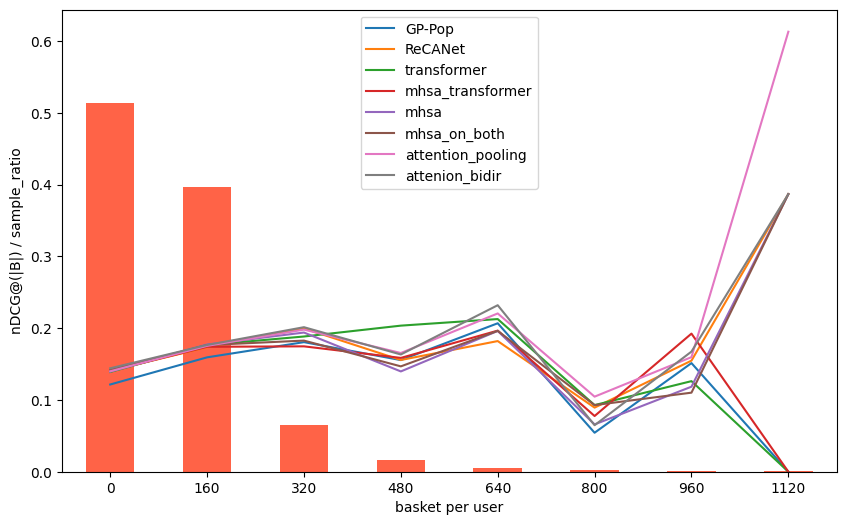

In [168]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
(some_df.groupby('group').count()['basket_id']/np.sum(some_df.groupby('group').count()['basket_id'])).plot(kind='bar', color='tomato')
for model_name in model_names:
    some_df.groupby('group').mean()[model_name].plot(label='ndcg')

plt.legend(model_names)
plt.title('')
plt.ylabel('nDCG@(|B|) / sample_ratio')
plt.xlabel('basket per user')

In [169]:
values = new_df_train[['user_id','item_id']].drop_duplicates().groupby('user_id').agg({'item_id':'count'}).reset_index()
values['groups'] = pd.cut(values['item_id'], [-150, 150] + [150 + i * 300 for i in range(1, 11)])

values['group'] = values['groups'].apply(lambda x: int(x.mid))

In [170]:
values = pd.merge(
    left=values,
    right=gp_pop_pred,
    on='user_id',
    how='inner'
)

values = pd.merge(
    left=values,
    right=output_baseline[1].rename(columns={'ndcg':'ReCANet'}),
    on='user_id',
    how='inner'
)

values = pd.merge(
    left=values,
    right=output_transformer[1].rename(columns={'ndcg':'transformer'}),
    on='user_id',
    how='inner'
)

values = pd.merge(
    left=values,
    right=output_mhsa_transformer[1].rename(columns={'ndcg':'mhsa_transformer'}),
    on='user_id',
    how='inner'
)

values = pd.merge(
    left=values,
    right=output_sep_mhsa[1].rename(columns={'ndcg':'mhsa'}),
    on='user_id',
    how='inner'
)

values = pd.merge(
    left=values,
    right=output_concat_mhsa[1].rename(columns={'ndcg':'mhsa_on_both'}),
    on='user_id',
    how='inner'
)

values = pd.merge(
    left=values,
    right=output_atten_pooling[1].rename(columns={'ndcg':'attention_pooling'}),
    on='user_id',
    how='inner'
)

values = pd.merge(
    left=values,
    right=output_bidir_attention[1].rename(columns={'ndcg':'attenion_bidir'}),
    on='user_id',
    how='inner'
)



/var/folders/cn/qdbsjz5932j50v7b3ww9tfmr0000gq/T/ipykernel_22209/2695135555.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  values.groupby('group').mean()[model_name].plot(label='ndcg')
/var/folders/cn/qdbsjz5932j50v7b3ww9tfmr0000gq/T/ipykernel_22209/2695135555.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  values.groupby('group').mean()[model_name].plot(label='ndcg')
/var/folders/cn/qdbsjz5932j50v7b3ww9tfmr0000gq/T/ipykernel_22209/2695135555.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either

Text(0.5, 0, 'item per user')

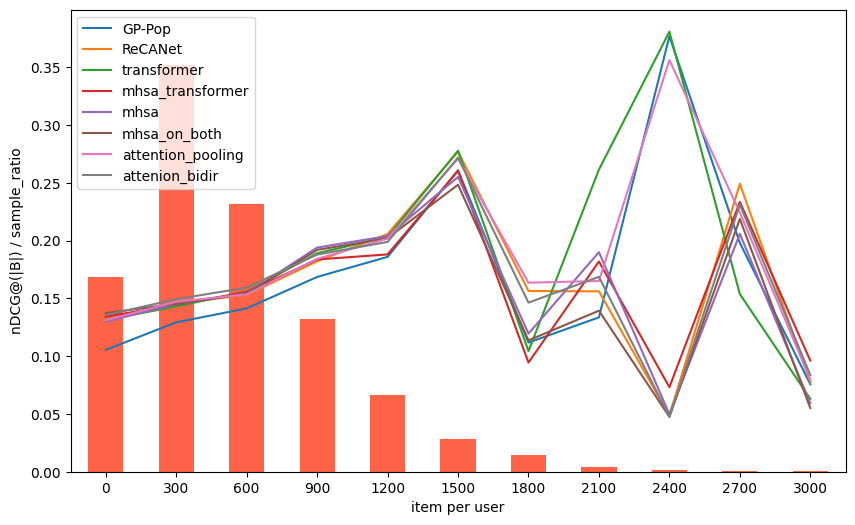

In [171]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
(values.groupby('group').count()['item_id']/np.sum(values.groupby('group').count()['item_id'])).plot(kind='bar', color='tomato')
for model_name in model_names:
    values.groupby('group').mean()[model_name].plot(label='ndcg')

plt.legend(model_names)
plt.title('')
plt.ylabel('nDCG@(|B|) / sample_ratio')
plt.xlabel('item per user')

In [172]:
avg_rep_ratio_df['groups'] =  pd.cut(avg_rep_ratio_df['avg_rep_ratio'], bins=7)

avg_rep_ratio_df['group'] = avg_rep_ratio_df['groups'].apply(lambda x: round(x.mid, 3))

In [173]:
avg_rep_ratio_df = pd.merge(
    left=avg_rep_ratio_df,
    right=gp_pop_pred,
    on='user_id',
    how='inner'
)

avg_rep_ratio_df = pd.merge(
    left=avg_rep_ratio_df,
    right=output_baseline[1].rename(columns={'ndcg':'ReCANet'}),
    on='user_id',
    how='inner'
)

avg_rep_ratio_df = pd.merge(
    left=avg_rep_ratio_df,
    right=output_transformer[1].rename(columns={'ndcg':'transformer'}),
    on='user_id',
    how='inner'
)

avg_rep_ratio_df = pd.merge(
    left=avg_rep_ratio_df,
    right=output_mhsa_transformer[1].rename(columns={'ndcg':'mhsa_transformer'}),
    on='user_id',
    how='inner'
)

avg_rep_ratio_df = pd.merge(
    left=avg_rep_ratio_df,
    right=output_sep_mhsa[1].rename(columns={'ndcg':'mhsa'}),
    on='user_id',
    how='inner'
)

avg_rep_ratio_df = pd.merge(
    left=avg_rep_ratio_df,
    right=output_concat_mhsa[1].rename(columns={'ndcg':'mhsa_on_both'}),
    on='user_id',
    how='inner'
)

avg_rep_ratio_df = pd.merge(
    left=avg_rep_ratio_df,
    right=output_atten_pooling[1].rename(columns={'ndcg':'attention_pooling'}),
    on='user_id',
    how='inner'
)

avg_rep_ratio_df = pd.merge(
    left=avg_rep_ratio_df,
    right=output_bidir_attention[1].rename(columns={'ndcg':'attenion_bidir'}),
    on='user_id',
    how='inner'
)



/var/folders/cn/qdbsjz5932j50v7b3ww9tfmr0000gq/T/ipykernel_22209/1396654172.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_rep_ratio_df.groupby('group').mean()[model_name].plot(label='ndcg')
/var/folders/cn/qdbsjz5932j50v7b3ww9tfmr0000gq/T/ipykernel_22209/1396654172.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_rep_ratio_df.groupby('group').mean()[model_name].plot(label='ndcg')
/var/folders/cn/qdbsjz5932j50v7b3ww9tfmr0000gq/T/ipykernel_22209/1396654172.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will defa

Text(0.5, 0, 'avg rep ratio per user ')

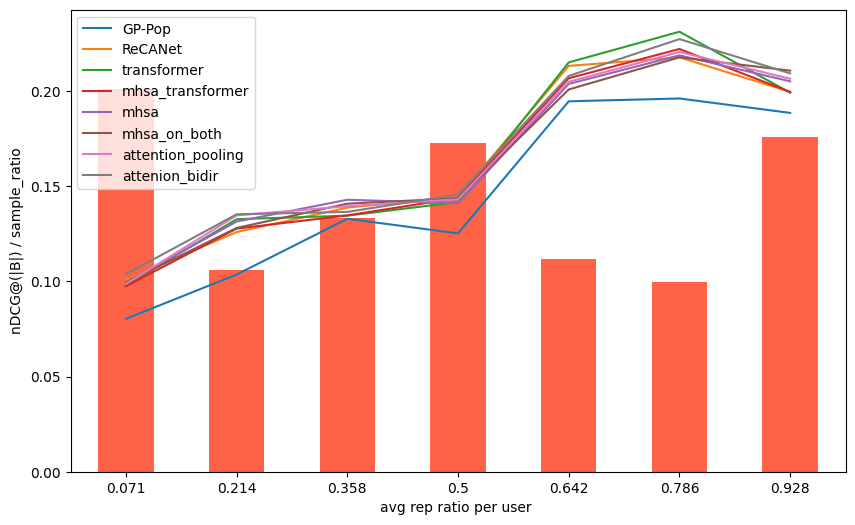

In [174]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
(avg_rep_ratio_df.groupby('group').count()['user_id']/np.sum(values.groupby('group').count()['user_id'])).plot(kind='bar', color='tomato')
for model_name in model_names:
    avg_rep_ratio_df.groupby('group').mean()[model_name].plot(label='ndcg')

plt.legend(model_names)
plt.title('')
plt.ylabel('nDCG@(|B|) / sample_ratio')
plt.xlabel('avg rep ratio per user ')

In [181]:
avg_item_per_basket = new_df_train.groupby(['basket_id']).count()[['item_id']]
temp = new_df_train[['user_id', 'basket_id']].drop_duplicates()
temp = pd.merge(
    left=temp,
    right=avg_item_per_basket,
    how='inner',
    on='basket_id'
)

In [182]:
temp['groups'] =  pd.cut(temp['item_id'], bins=20)

temp['group'] = temp['groups'].apply(lambda x: round(x.mid, 2))

In [183]:
temp = pd.merge(
    left=temp,
    right=gp_pop_pred,
    on='user_id',
    how='inner'
)

temp = pd.merge(
    left=temp,
    right=output_baseline[1].rename(columns={'ndcg':'ReCANet'}),
    on='user_id',
    how='inner'
)

temp = pd.merge(
    left=temp,
    right=output_transformer[1].rename(columns={'ndcg':'transformer'}),
    on='user_id',
    how='inner'
)

temp = pd.merge(
    left=temp,
    right=output_mhsa_transformer[1].rename(columns={'ndcg':'mhsa_transformer'}),
    on='user_id',
    how='inner'
)

temp = pd.merge(
    left=temp,
    right=output_sep_mhsa[1].rename(columns={'ndcg':'mhsa'}),
    on='user_id',
    how='inner'
)

temp = pd.merge(
    left=temp,
    right=output_concat_mhsa[1].rename(columns={'ndcg':'mhsa_on_both'}),
    on='user_id',
    how='inner'
)

temp = pd.merge(
    left=temp,
    right=output_atten_pooling[1].rename(columns={'ndcg':'attention_pooling'}),
    on='user_id',
    how='inner'
)

temp = pd.merge(
    left=temp,
    right=output_bidir_attention[1].rename(columns={'ndcg':'attenion_bidir'}),
    on='user_id',
    how='inner'
)



In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
(temp.groupby('group').count()['item_id']/np.sum(temp.groupby('group').count()['item_id'])).plot(kind='bar', color='tomato')
for model_name in model_names:
    temp.groupby('group').mean()[model_name].plot()

plt.legend(model_names)
plt.title('')
plt.ylabel('ndcg(|B|) / sample_ratio')
plt.xlabel('avg items in bucket per user')